<a href="https://colab.research.google.com/github/Tommy840602/Decision-Tree/blob/main/Decision%20-Tree_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_style('whitegrid')
sns.set_context('talk')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)

In [3]:
hour_df = pd.read_csv("/content/hour.csv")
hour_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


In [4]:
#data process
hour_df.rename(columns={'instant':'rec_id',
                        'dteday':'datetime',
                        'holiday':'is_holiday',
                        'workingday':'is_workingday',
                        'weathersit':'weather_condition',
                        'hum':'humidity',
                        'mnth':'month',
                        'cnt':'total_count',
                        'hr':'hour',
                        'yr':'year'},inplace=True)

hour_df['datetime'] = pd.to_datetime(hour_df.datetime)
hour_df['season'] = hour_df.season.astype('category')
hour_df['is_holiday'] = hour_df.is_holiday.astype('category')
hour_df['weekday'] = hour_df.weekday.astype('category')
hour_df['weather_condition'] = hour_df.weather_condition.astype('category')
hour_df['is_workingday'] = hour_df.is_workingday.astype('category')
hour_df['month'] = hour_df.month.astype('category')
hour_df['year'] = hour_df.year.astype('category')
hour_df['hour'] = hour_df.hour.astype('category')

In [5]:
#Feature Engineering
def fit_transform_ohe(df,col_name):
    le = preprocessing.LabelEncoder()
    le_labels = le.fit_transform(df[col_name])
    df[col_name+'_label'] = le_labels
    ohe = preprocessing.OneHotEncoder()
    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return le,ohe,features_df

def transform_ohe(df,le,ohe,col_name):
    col_labels = le.transform(df[col_name])
    df[col_name+'_label'] = col_labels

    feature_arr = ohe.fit_transform(df[[col_name+'_label']]).toarray()
    feature_labels = [col_name+'_'+str(cls_label) for cls_label in le.classes_]
    features_df = pd.DataFrame(feature_arr, columns=feature_labels)
    return features_df

In [13]:
X, X_test, y, y_test = train_test_split(hour_df.iloc[:,0:-3],hour_df.iloc[:,-1],test_size=0.33,random_state=42)
X.reset_index(inplace=True)
y = y.reset_index()

X_test.reset_index(inplace=True)
y_test = y_test.reset_index()

In [14]:
cat_attr_list = ['season','is_holiday','weather_condition','is_workingday','hour','weekday','month','year']
numeric_feature_cols = ['temp','humidity','windspeed','hour','weekday','month','year']
subset_cat_features =  ['season','is_holiday','weather_condition','is_workingday']

encoded_attr_list = []
for col in cat_attr_list:
    return_obj = fit_transform_ohe(X,col)
    encoded_attr_list.append({'label_enc':return_obj[0],'ohe_enc':return_obj[1],'feature_df':return_obj[2],'col_name':col})


feature_df_list  = [X[numeric_feature_cols]]
feature_df_list.extend([enc['feature_df'] \
            for enc in encoded_attr_list \
            if enc['col_name'] in subset_cat_features])

train_df_new = pd.concat(feature_df_list, axis=1)
print("Train dataset shape::{}".format(train_df_new.shape))
print(train_df_new.head())

test_encoded_attr_list = []
for enc in encoded_attr_list:
    col_name = enc['col_name']
    le = enc['label_enc']
    ohe = enc['ohe_enc']
    test_encoded_attr_list.append({'feature_df':transform_ohe(X_test,le,ohe,col_name),'col_name':col_name})

test_feature_df_list = [X_test[numeric_feature_cols]]
test_feature_df_list.extend([enc['feature_df'] \
              for enc in test_encoded_attr_list \
              if enc['col_name'] in subset_cat_features])

test_df_new = pd.concat(test_feature_df_list, axis=1)
print("Test dataset shape::{}".format(test_df_new.shape))
print(test_df_new.head())

Train dataset shape::(11643, 19)
   temp  humidity  windspeed hour weekday month year  season_1  season_2  \
0  0.64      0.65     0.1940    0       5     9    0       0.0       0.0   
1  0.50      0.45     0.2239   13       2     3    0       0.0       1.0   
2  0.86      0.47     0.5224   12       0     8    1       0.0       0.0   
3  0.30      0.61     0.0000    2       3     2    1       1.0       0.0   
4  0.54      0.19     0.4179   17       6     4    1       0.0       1.0   

   season_3  season_4  is_holiday_0  is_holiday_1  weather_condition_1  \
0       1.0       0.0           1.0           0.0                  1.0   
1       0.0       0.0           1.0           0.0                  1.0   
2       1.0       0.0           1.0           0.0                  1.0   
3       0.0       0.0           1.0           0.0                  1.0   
4       0.0       0.0           1.0           0.0                  1.0   

   weather_condition_2  weather_condition_3  weather_condition_4 

In [15]:
#Model
X = train_df_new
y= y.total_count.values.reshape(-1,1)

X_test = test_df_new
y_test = y_test.total_count.values.reshape(-1,1)
print(X.shape,y.shape)

(11643, 19) (11643, 1)


In [19]:
dtm = DecisionTreeRegressor(max_depth=4,min_samples_split=5,max_leaf_nodes=10)

dtm.fit(X,y)
print("R-Squared on train dataset={}".format(dtm.score(X_test,y_test)))

dtm.fit(X_test,y_test)
print("R-Squared on test dataset={}".format(dtm.score(X_test,y_test)))

R-Squared on train dataset=0.5617444790362427
R-Squaredon test dataset=0.5668794949265306


In [26]:
#Hyperparameter tuning with GridSearchCV
param_grid = {"criterion": ["squared_error", "poisson", "friedman_mse", "absolute_error"],
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40, 100],
              "max_leaf_nodes": [5, 20, 100],
              }
grid_cv_dtm = GridSearchCV(dtm,param_grid,cv=5)
grid_cv_dtm.fit(X,y)

GridSearchCV(cv=5,
             estimator=DecisionTreeRegressor(max_depth=4, max_leaf_nodes=10,
                                             min_samples_split=5),
             param_grid={'criterion': ['squared_error', 'poisson',
                                       'friedman_mse', 'absolute_error'],
                         'max_depth': [2, 6, 8], 'max_leaf_nodes': [5, 20, 100],
                         'min_samples_leaf': [20, 40, 100],
                         'min_samples_split': [10, 20, 40]})

In [27]:
print("R-Squared::{}".format(grid_cv_dtm.best_score_))
print("Best Hyperparameters::\n{}".format(grid_cv_dtm.best_params_))

R-Squared::0.8320445160718
Best Hyperparameters::
{'criterion': 'squared_error', 'max_depth': 8, 'max_leaf_nodes': 100, 'min_samples_leaf': 20, 'min_samples_split': 10}


In [28]:
df = pd.DataFrame(data=grid_cv_dtm.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011667,0.001713,0.003123,0.000065,squared_error,2,5,20,10,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,244
1,0.011436,0.001715,0.003979,0.001582,squared_error,2,5,20,20,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,244
2,0.010315,0.000083,0.002865,0.000069,squared_error,2,5,20,40,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,244
3,0.010467,0.000747,0.002801,0.000078,squared_error,2,5,40,10,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,244
4,0.010894,0.001096,0.002844,0.000160,squared_error,2,5,40,20,"{'criterion': 'squared_error', 'max_depth': 2,...",0.392674,0.400027,0.417498,0.399368,0.417796,0.405472,0.010268,244


[Text(0.5, 1.0, 'Effect of Depth and Leaf Nodes on Model Performance')]

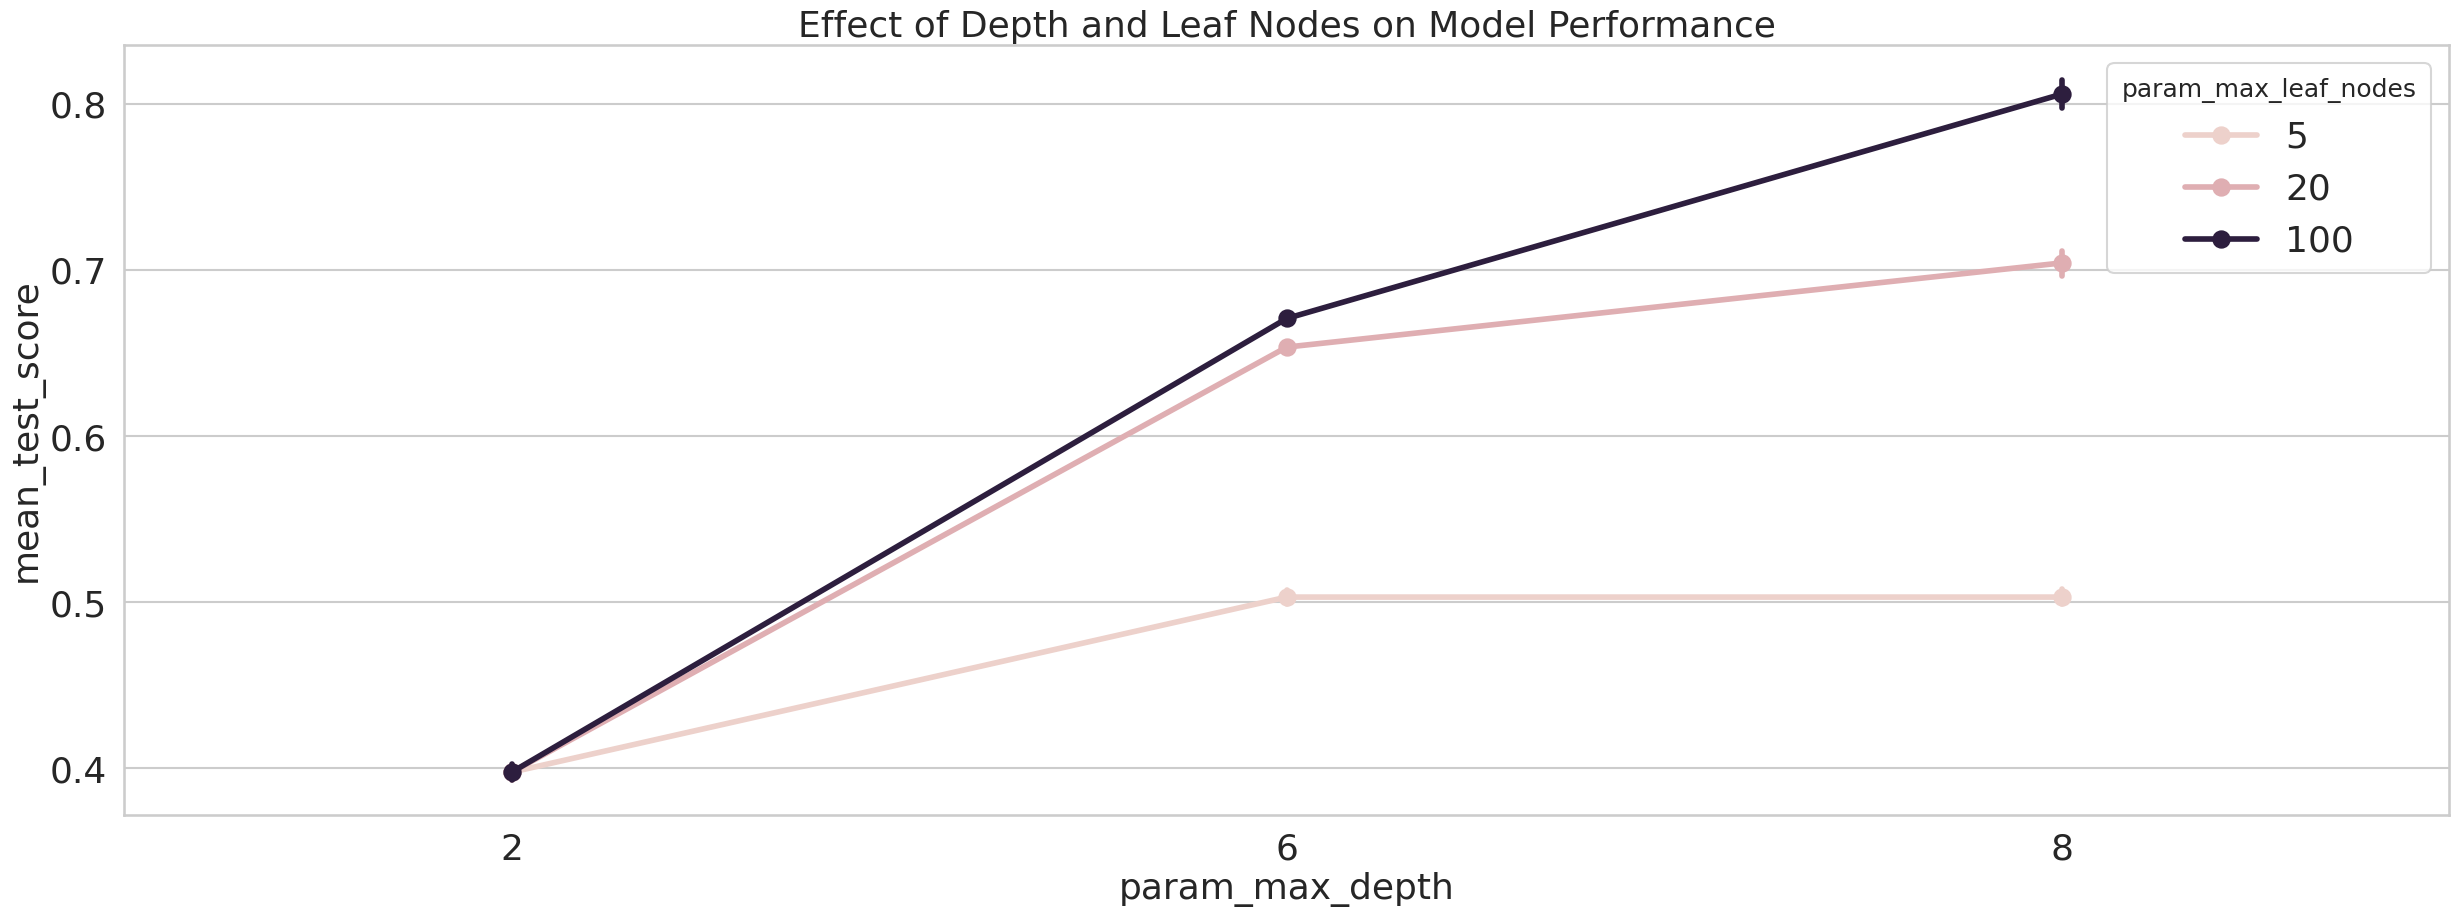

In [29]:
fig,ax = plt.subplots()
sns.pointplot(data=df[['mean_test_score','param_max_leaf_nodes','param_max_depth']],
             y='mean_test_score',x='param_max_depth',
             hue='param_max_leaf_nodes',ax=ax)
ax.set(title="Effect of Depth and Leaf Nodes on Model Performance")

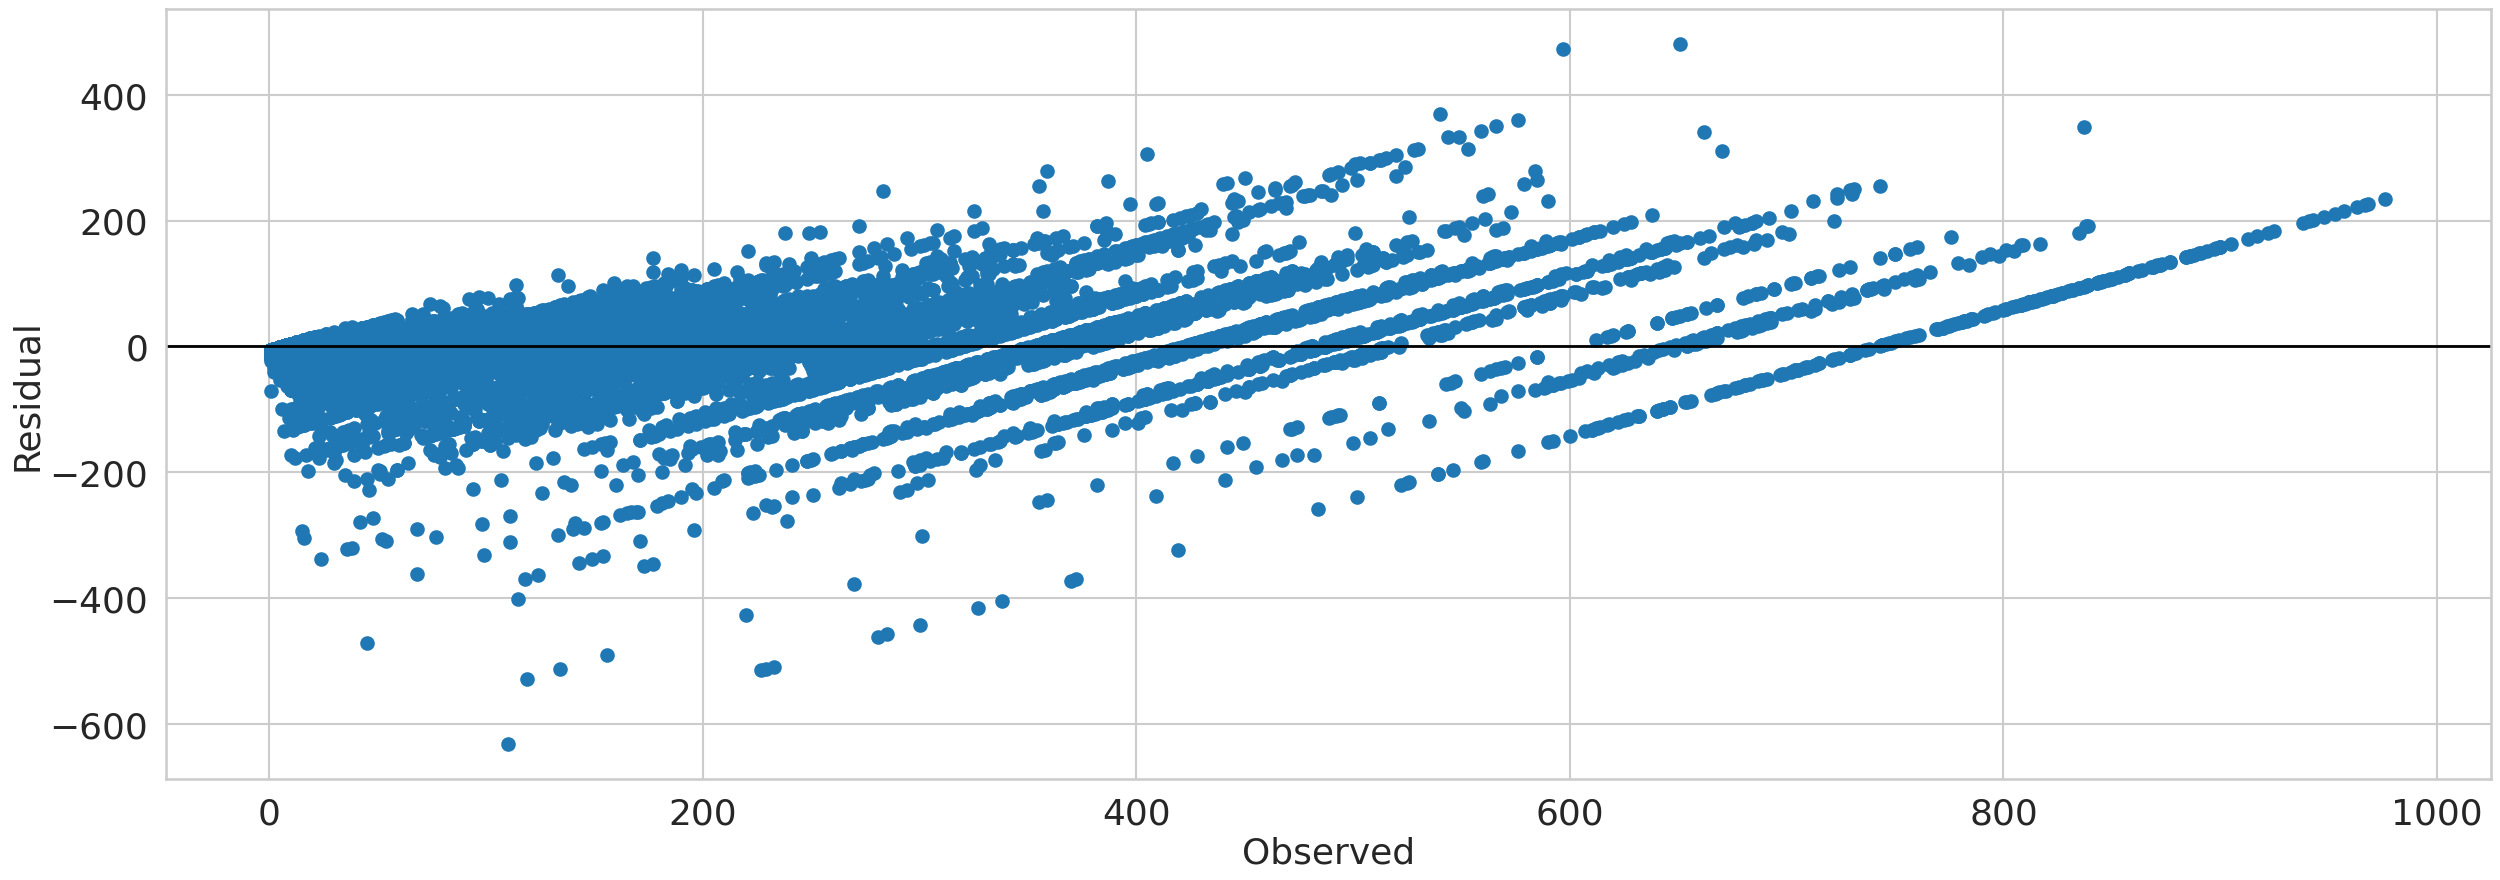

In [30]:
predicted = grid_cv_dtm.best_estimator_.predict(X)
residuals = y.flatten()-predicted
fig, ax = plt.subplots()
ax.scatter(y.flatten(), residuals)
ax.axhline(lw=2,color='black')
ax.set_xlabel('Observed')
ax.set_ylabel('Residual')
plt.show()

In [31]:
r2_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10)
mse_scores = cross_val_score(grid_cv_dtm.best_estimator_, X, y, cv=10,scoring='neg_mean_squared_error')
print("avg R-squared::{:.3f}".format(np.mean(r2_scores)))
print("MSE::{:.3f}".format(np.mean(mse_scores)))

avg R-squared::0.836
MSE::-5466.263


In [32]:
best_dtm_model = grid_cv_dtm.best_estimator_

y_pred = best_dtm_model.predict(X_test)
residuals = y_test.flatten() - y_pred

r2_score = best_dtm_model.score(X_test,y_test)
print("R-squared:{:.3f}".format(r2_score))
print("MSE: %.2f" % metrics.mean_squared_error(y_test, y_pred))

R-squared:0.846
MSE: 4897.24
